This week, we would like to scale the exercises back a little bit and give you a time to understand the previous material better. We are going to do another tour of tensorflow and there are a few required readings.

# Vectorization

Required Reading:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html

Extra material (really great but a little mathy):
1. [Vectors, Matrix, and Tensor Derivatives](http://cs231n.stanford.edu/vecDerivs.pdf)
2. [Derivatives, Backprop, and Vectorization](http://cs231n.stanford.edu/handouts/derivatives.pdf)

Most of the functions you call using NumPy in your Python code are merely wrappers for underlying code in C where most of the heavy lifting happens. In this way, NumPy can move the execution of loops to C, which is much more efficient than Python when it comes to looping. Notice this can be only done as the array enforces the elements of the array to be of the same kind. Otherwise, it would not be possible to convert the Python data types to native C ones to be executed under the hood.

Some tips:
1. Use dimension analysis! You usually know what the output shape should be. Compose operations to get it right.
2. Start small! Explicitly write out a minimal vectorized example, derive the gradient on paper and then generalize the pattern to its efficient, vectorized form.
3. Build up! Start by vectorizing a single example by hand. Then add more datapoints and see what happens. Change as needed.
3. Not everything is a matrix multiplication! Think about the Logistic Loss function which has a log in it. You cannot make it a matrix multiplication because it will always be an elementwise operation. In this case, you should be able to obtain a large matrix/vector through matrix multiplications and then you will call the `np.log` function on it to take an elementwise log. Then you will call the `np.mean` function to obtain the final loss value. Similarly, sometimes, we take elementwise products and not matrix multiplications.





# Extremely useful extra material on Gradient Descent
1. https://cs231n.github.io/optimization-1/
2. [Roger Grosse - 8](https://www.cs.toronto.edu/~lczhang/321/notes/notes08.pdf)

# Multi-class classification example with Tensorflow

Last week, we did a very quick tour of the basics of Tensorflow. We are still going to remain in a tour mode this week. We will go through an example of a multi-class MLP model in Tensorflow which showcases everything you need to get started with deep learning.

Tensorflow hides a lot of details of the computation - both of the computation of the prediction, and the computation of the gradients. In the later
labs, we will get into those details to some extent which hopefully will improve your understanding of what is happening when you use the higher level API to compose your models and also improve your practical skills in building machine learning models.

In this example, we will use the FashionMNIST dataset, which contains 28x28 pixel images of clothing items

In [1]:
%matplotlib inline

## Data

The Fashion MNIST dataset contains 70,000 grayscale images in 10 categories.
The images show individual articles of clothing at a low resolution (28 by 28 pixels). This is a data set that is typically used for
demonstrations of machine learning models, and as one of the first datasets to test new types of models.

We will download the dataset. For simplicity, we'll only use the first 2500
images in the FashionMNIST dataset for training and 500 for testing. 

Import tensorflow

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-02-20 19:00:33.658729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 19:00:43.912190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 19:00:43.912293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-20 19:00:43.912302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

2.11.0


You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# select first 2500 training samples
train_images, train_labels = train_images[:2500], train_labels[:2500]

# select first 500 testing samples
test_images, test_labels = test_images[:500], test_labels[:500]

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at some of the data:

Let's explore the format of the dataset before training the model. The following shows there are 2,500 images in the training set, with each image represented as 28 x 28 pixels:

In [5]:
train_images.shape

(2500, 28, 28)

And the range of the image values is:

In [6]:
train_images.max(), train_images.min()

(255, 0)

Each label is an integer between 0 and 9:

In [7]:
train_labels

array([9, 0, 0, ..., 5, 8, 3], dtype=uint8)

Again in test set, each image is represented as 28 x 28 pixels:

In [8]:
test_images.shape

(500, 28, 28)

And the range of the image values is:

In [9]:
test_images.max(), test_images.min()

(255, 0)

And the test set also has labels between 0 and 9.

In [10]:
test_labels

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5,
       7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7,
       6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1,
       2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
       0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4,
       2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1,
       9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4, 1, 4,
       5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1,
       3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3,
       6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2,
       8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6,
       9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0,
       0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6,
       6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3,

Let's plot a few images:

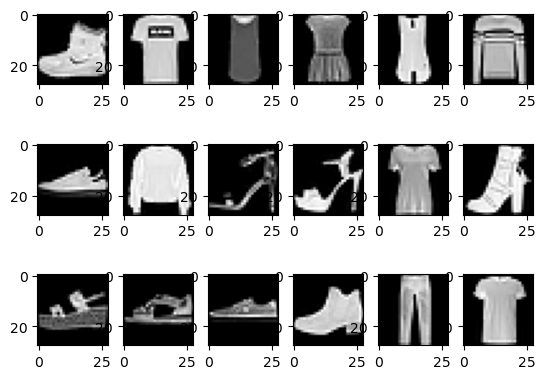

In [11]:
# plot the first 18 images in the training data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(zip(train_images[:18], train_labels[:18])):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

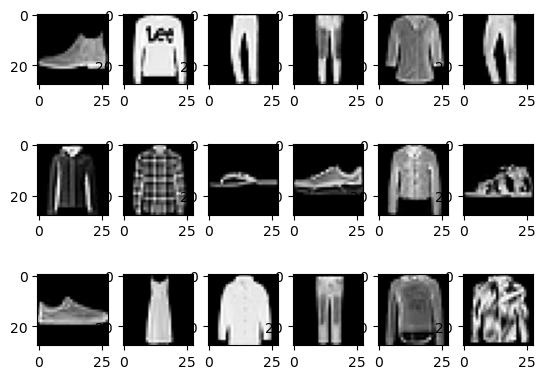

In [12]:
# plot the first 18 images in the testing data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(zip(test_images[:18], test_labels[:18])):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

In this case, we did not need to divide our data in training and testing sets becuase it was already loaded in that way. Normally we would have to do it ourselves.

## Data Preprocessing and Loading
Since our data is in a NumPy array format, we can directly perform any preprocessing steps as NumPy operations and also we will be able to directly load it in the model. There are a lot of functionalities in Tensorflow for loading all kinds of data and performing augmentations. We will skip over it for now.

The images are in the format `uint8`. For deep learning we need them to in `float32` format. It is also desirable to have the range of pixel values be normalised to lie between 0 and 1 (or -1 and 1). That is the only Preprocessing step we need to perform for this data.

Since the image values lie betwen 0 and 255, we can achieve both the above goals by just dividing by 255.0.

In [13]:
train_images = train_images/255.0
test_images = test_images/255.0

Let's plot a few images again to see if anything went wrong.

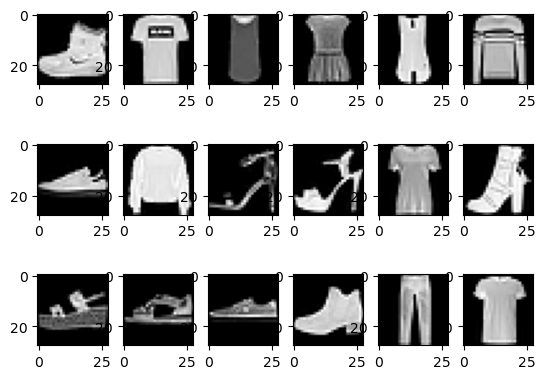

In [14]:
# plot the first 18 images in the training data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(zip(train_images[:18], train_labels[:18])):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

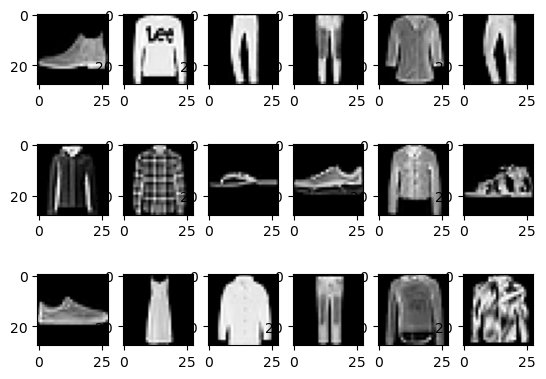

In [15]:
# plot the first 18 images in the testing data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(zip(test_images[:18], test_labels[:18])):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

## Building a model
There are many ways to build a model in Tensorflow. But I am going to stick to the functional way that we saw last week. Personally, I tend to avoid using the `tf.keras.Sequential` to create the models, instead preferring either the functional way or subclassing way (where you create the model as Subclass of the general `tf.keras.Model` class provided in Tensorflow). For linear regression
and binary classification, the number of output features is 1. For multi-class classification,
we have as many outputs as there are classes.

In tensorflow, nothing really changes if we want to make this a CNN instead of MLP. We would just add the proper convolutional layers instead of the dense layers.

We will start by specifying the number of input features. Remember that the `input_size` is the shape of the *individual data sample*. For us it is (28,28).

Then we flatten it out to make it a vector. We will apply 3 dense layers with a ReLU activation. Recall that dense layers are fully connected. 

For linear regression and binary classification, the number of output features is 1. For multi-class classification, we have as many outputs as there are classes - so ten.

When using this model for classification, we'll need to apply the sigmoid or softmax activiation *afterwards*. That is, this model is only meant to ouput the linear part of the model computation. Many times the implemetation of the loss function applies the sigmoid or the softmax. We can look at the documentation to figure out if we need to do it or the loss function will do it for us.

In [16]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(28,28))
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    output = tf.keras.layers.Dense(10, activation="linear")(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)

    return model

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of three `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first two `Dense` layers have 512 nodes (or neurons). The last layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

Let's create a model!

In [17]:
example_model = build_model()

2023-02-20 19:01:49.886126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 19:01:49.938305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 19:01:49.938597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 19:01:49.939362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

The `example_model` object contains weights and biases of the model. By default, Tensorflow
initializes these values to a random number close to 0:

In [18]:
example_model.layers[2].get_weights()[0]

array([[-0.02641463, -0.0467603 ,  0.03590859, ..., -0.06461528,
         0.03442593, -0.00513813],
       [-0.02260989, -0.01076756,  0.02687341, ..., -0.03665976,
        -0.04445804, -0.01783649],
       [-0.05109301,  0.04099905, -0.06417121, ..., -0.05515429,
        -0.02336244,  0.02365443],
       ...,
       [-0.05677494,  0.04233748, -0.01561109, ...,  0.05051679,
         0.04902279,  0.03313659],
       [ 0.05321567, -0.05256564,  0.04916918, ..., -0.00658593,
        -0.00151055, -0.05519745],
       [ 0.01405241,  0.03238562, -0.05335054, ...,  0.06611075,
        -0.00021316,  0.0617442 ]], dtype=float32)

If we create a new model, those initial parameters will change:

In [19]:
example_model = build_model()
example_model.layers[2].get_weights()[0]

array([[-0.03902329,  0.05209775,  0.02899466, ...,  0.02058732,
        -0.00636774, -0.02684849],
       [-0.06752267,  0.05205008, -0.04689256, ..., -0.01786515,
        -0.04147385,  0.04819208],
       [ 0.06007859, -0.02603995, -0.04335567, ...,  0.04844546,
         0.03467212, -0.06056273],
       ...,
       [ 0.00268038,  0.06483129,  0.06611761, ..., -0.01079473,
        -0.05156171, -0.02769958],
       [-0.00116734,  0.01884613,  0.04257862, ..., -0.05134235,
        -0.02103517, -0.03390391],
       [-0.00460208,  0.04565838,  0.0086944 , ...,  0.00055896,
         0.01923467, -0.06371737]], dtype=float32)

## Making Predictions

Let's see how we can make a prediction with this model. (You might find it strange that 
we're talking about how to make predictions *before* talking about how to train the model.
The reason is that we will always train the model using a varient of gradient descent.
So you can imagine that the weights of this model will eventually become more meaningful
than it is now)

We'll start with the simpler `example_model` first. The way that we make predictions
is by starting with an input $x$ that has the required shape. Since `example_model` is
just an example, we'll create a tensor with the appropriate shape, filled with random values.

In [20]:
x = np.random.random((1,28,28))

To make predictions, we apply the `example_model` as if it is a function, with the 
inputs as an argument:

In [21]:
y = example_model(x)
y.shape

2023-02-20 19:01:52.307030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([1, 10])

If this model was used for classification, we might also need to apply the softmax 
function:

In [22]:
tf.nn.softmax(y)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.09772113, 0.14126405, 0.04074944, 0.11633173, 0.11709436,
        0.08917575, 0.13459572, 0.11098772, 0.05261838, 0.09946171]],
      dtype=float32)>

One nice thing about Tensorflow is that it vectorizes and parallelizes the computation for us.
So, if we had a *batch* of 32 inputs that we want to make predictions for, we can perform
that computation using a single call:

In [23]:
x = x = np.random.random((32,28,28)) # a stack of 32 inputs
y = example_model(x)
print(y.shape)

(32, 10)


(Note: The order of the dimensions in our input $x$ matters. The batch size always goes first,
and the number of features always goes second)

Now, let's try and make some "predictions" with FashionMNIST! We will take one image into the variable `image_tensor`:

In [24]:
image_tensor = train_images[4]

In [25]:
x = image_tensor.reshape((-1, 28, 28)) # can you recall this kind of usage from before?
print(x.shape)
z = example_model(x)
print(z)
print(z.shape)
y = tf.nn.softmax(z, axis=1)
print(y)

(1, 28, 28)
tf.Tensor(
[[ 0.12231719 -0.04992092 -0.20589505 -0.16031621 -0.13709703 -0.17444555
  -0.17782855  0.24535304  0.06439519  0.0088916 ]], shape=(1, 10), dtype=float32)
(1, 10)
tf.Tensor(
[[0.1171147  0.09858466 0.08434719 0.0882806  0.09035438 0.08704203
  0.08674806 0.13244793 0.11052389 0.10455656]], shape=(1, 10), dtype=float32)


The `axis=1` in the softmax tells Tensorflow which dimension represents different
images, and which one represents the different class labels. We want our
outputs $y$ to be a probability distribution across the *classes*, and not
the different images.

## Loss Function

In order for the network to be useful, we need to actually train it, so
that the weights are actually meaningful, non-random values. As we mentioned
before, we'll use the network to make predictions, then compare the predictions
agains the ground truth via the loss function.

Tensorflow has standard loss functions that we can use: for example,
`tf.keras.losses.SparseCategoricalCrossentropy()` for a multi-class classification problem like ours.

In [26]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The `from_logits` argument is related to the earlier discussion about if we should apply softmax ourselves or keep the final activation linear.

This criterion can also be called as a function. It takes the logit prediction and
ground-truth as parameters, and returns the loss. Two things to keep in mind
for this function:

1. Setting the `from_logits` argument to `True` takes the **logit** as parameter, rather than
   the post-softmax probability distributions. This is for numerical stability.
2. This loss function also takes the ground-truth integer **index** as a parameter,
   rather than a one-hot vector.

In [27]:
loss = criterion(tf.constant(8), y) # digit 8 = the 8-th class
print(loss)

tf.Tensor(2.2921765, shape=(), dtype=float32)


## Model Compilation
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function — We already have it above.

Optimizer — This is how the model is updated based on the data it sees and its loss function. There are a number of algorithms implemented in Tensorflow.

Metrics — Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [28]:
example_model.compile(optimizer='adam', # probably the most common optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training

Training the neural network model requires the following parameters:

1. The training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. Number of epochs - how many iterations performed on the entire dataset?
3. Batch size - how many exmaples are shown in a minibatch?

To run the training process, we use `model.fit()` method. It returns a `history` object which stores the values of metrics and loss for each epoch. We can optionally also pass in the validation data set so that after each epoch we see how well the model is performing.


In [29]:
history = example_model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10


2023-02-20 19:01:53.636972: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e76b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-20 19:01:53.637050: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-02-20 19:01:53.649840: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-20 19:01:53.759748: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-20 19:01:53.836057: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 2s 4ms/step - loss: 0.8770 - accuracy: 0.6948
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 0.5437 - accuracy: 0.8092
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 0.4901 - accuracy: 0.8220
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 0.4381 - accuracy: 0.8404
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.8644
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 0.3618 - accuracy: 0.8740
Epoch 7/10
79/79 [==============================] - 0s 3ms/step - loss: 0.3230 - accuracy: 0.8784
Epoch 8/10
79/79 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.8892
Epoch 9/10
79/79 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.8772
Epoch 10/10
79/79 [==============================] - 0s 3ms/step - loss: 0.3132 - accuracy: 0.8844


We can use the `history` object to plot the loss and accuracy curves.

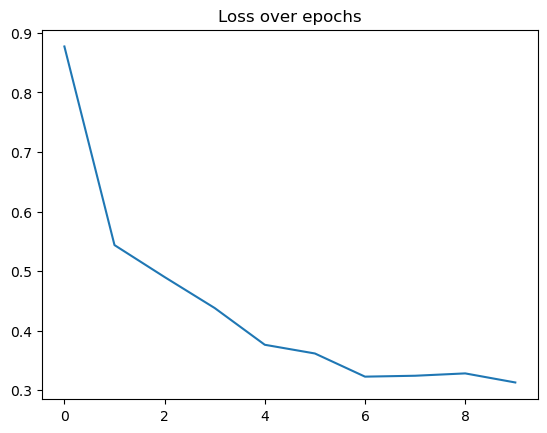

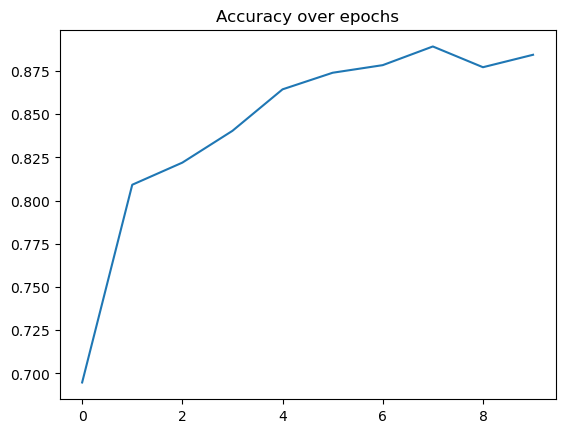

In [30]:
losses = history.history["loss"]
accuracies = history.history["accuracy"]

plt.figure()
plt.plot(losses)
plt.title("Loss over epochs")
plt.show()


plt.figure()
plt.plot(accuracies)
plt.title("Accuracy over epochs")
plt.show()

# ⏰ Exercise: find out how to evaluate the model performance and find the accuracy of the trained model on our testing data.

In [31]:
test_logits = example_model(test_images)
test_preds = tf.nn.softmax(test_logits, axis=1)
test_pred_labels = np.argmax(test_preds, axis = 1)

m = tf.keras.metrics.Accuracy()
m.update_state(test_labels, test_pred_labels)
print(m.result().numpy())

0.84


## Things to try:

- Changing the batch size
- Changing the weight decay parameter
- Reduce the size of the training set (+ weight decay)
- Changing the learning rate (for your project)

# Mandatory Reading: [Machine Learning Pipeline](https://deepimaging.github.io/tasess/previous/MachineLearningPipeline.pdf)